<a href="https://colab.research.google.com/github/qkrdudwls/Exploring-the-Bible-and-Quran-Books/blob/main/Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **성경과 코란의 유사도 분석**


## Overview
- Bible과 Quran의 본문을 chapter 별로 crawling
- Shingling, Min-Hashing, LSH 알고리즘을 적용하여 유사도 계산 및 가장 유사한 문서 쌍 찾기

## Set up


### 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Selenium & chromedriver 설치

In [ ]:
!pip install selenium
!apt-get update

!apt install chromium-chromedriver
!cp /usr/bin/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 34.4 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,458 kB]
Get:11 http://security.ubuntu.c

### Spark 설치

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 54 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 124097 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

### Datasketch 설치

In [ ]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 6.6 MB/s eta 0:00:00


#### Version 확인

In [ ]:
!python --version

import selenium
import pyspark
import datasketch

print(f"Selenium {selenium.__version__}")
print(f"PySpark {pyspark.__version__}")
print(f"Datasketch {datasketch.__version__}")

Python 3.10.12
Selenium 4.27.1
PySpark 3.5.3
Datasketch 1.6.5


### Import library

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller
import re

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lit
from datasketch import MinHash, MinHashLSH
from pyspark.sql.types import ArrayType, StringType
import hashlib

import numpy as np
import random
from collections import Counter
import math

import networkx as nx
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from itertools import combinations
import hashlib
from collections import defaultdict

### chrome_options 설정

In [ ]:
chrome_path="/content/drive/Mydrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration

chromedriver_autoinstaller.install()  # set the target URL

## Crawling

#### URL

In [ ]:
bible_url = 'https://www.gutenberg.org/cache/epub/10/pg10-images.html'
quran_url = 'https://www.gutenberg.org/cache/epub/2800/pg2800-images.html'

#### 데이터 전처리 함수
- 영어 알파벳과 공백, 마침표만 제외하고 모두 제거
- 모든 문자를 소문자로 변환
- 연속된 공백을 단일 공백으로 축소
- 양 끝의 공백 제거

In [ ]:
def preprocess_text(text):
    sentences = re.split(r'(?<=[.?!])\s+', text)

    cleaned_sentences = []
    for sentence in sentences:
        sentence = re.sub(r'[?!]', '.', sentence)
        cleaned_sentence = re.sub(r'[^a-zA-Z\s.]', '', sentence)
        cleaned_sentence = cleaned_sentence.lower()
        cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence).strip()
        cleaned_sentence = re.sub(r'\.{2,}', '.', cleaned_sentence)
        cleaned_sentences.append(cleaned_sentence)

    return '. '.join(cleaned_sentences)

### Bible

In [ ]:
bible_chapter_driver = webdriver.Chrome(options=chrome_options)
bible_chapter_driver.get(bible_url)
wait = WebDriverWait(bible_chapter_driver, 10)

output_folder = "bible_texts"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

try:
    chapter_divs = bible_chapter_driver.find_elements(By.CLASS_NAME, "chapter")

    for index, chapter_div in enumerate(chapter_divs[1:], start=2):
        p_elements = chapter_div.find_elements(By.TAG_NAME, "p")

        chapter_text = ""
        for p_element in p_elements:
            text = p_element.text.strip()
            if text:
                processed_text = preprocess_text(text)
                chapter_text += processed_text + "\n"

        if chapter_text.strip():
            filename = os.path.join(output_folder, f"chapter_{index-1}.txt")
            with open(filename, "w", encoding="utf-8") as file:
                file.write(chapter_text.strip())
            print(f"Saved chapter {index-1} to {filename}")

except Exception as e:
    print("Error:", e)

finally:
    bible_chapter_driver.quit()

Saved chapter 1 to bible_texts/chapter_1.txt
Saved chapter 2 to bible_texts/chapter_2.txt
Saved chapter 3 to bible_texts/chapter_3.txt
Saved chapter 4 to bible_texts/chapter_4.txt
Saved chapter 5 to bible_texts/chapter_5.txt
Saved chapter 6 to bible_texts/chapter_6.txt
Saved chapter 7 to bible_texts/chapter_7.txt
Saved chapter 8 to bible_texts/chapter_8.txt
Saved chapter 9 to bible_texts/chapter_9.txt
Saved chapter 10 to bible_texts/chapter_10.txt
Saved chapter 11 to bible_texts/chapter_11.txt
Saved chapter 12 to bible_texts/chapter_12.txt
Saved chapter 13 to bible_texts/chapter_13.txt
Saved chapter 14 to bible_texts/chapter_14.txt
Saved chapter 15 to bible_texts/chapter_15.txt
Saved chapter 16 to bible_texts/chapter_16.txt
Saved chapter 17 to bible_texts/chapter_17.txt
Saved chapter 18 to bible_texts/chapter_18.txt
Saved chapter 19 to bible_texts/chapter_19.txt
Saved chapter 20 to bible_texts/chapter_20.txt
Saved chapter 21 to bible_texts/chapter_21.txt
Saved chapter 22 to bible_texts

### Quran

In [ ]:
quran_chapter_driver = webdriver.Chrome(options=chrome_options)
quran_chapter_driver.get(quran_url)
wait = WebDriverWait(quran_chapter_driver, 10)

output_dir = 'quran_texts'
os.makedirs(output_dir, exist_ok=True)

current_document = []
chapter_count = 1
start_crawling = False

try:
    elements = quran_chapter_driver.find_elements(By.XPATH, "//*[name()='h4' or name()='p' or @id='pg-end-separator']")

    for element in elements:
        if element.tag_name == 'div' and element.get_attribute('id') == 'pg-end-separator':
            break

        if element.tag_name == 'h4':
            start_crawling = True

            if current_document:
                quran_processed_text = ''.join(current_document)

                with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
                    file.write(quran_processed_text)

                print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")  # 진행 상황 출력

                chapter_count += 1
                current_document = []

        if start_crawling and element.tag_name == 'p':
            raw_text = element.text.strip()
            processed_text = preprocess_text(raw_text)
            current_document.append(processed_text + '\n')

    if current_document:
        quran_processed_text = ''.join(current_document)
        with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
            file.write(quran_processed_text)
        print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")

except Exception as e:
    print("Error:", e)

finally:
    quran_chapter_driver.quit()

Saved chapter 1 to quran_texts/chapter_1.txt
Saved chapter 2 to quran_texts/chapter_2.txt
Saved chapter 3 to quran_texts/chapter_3.txt
Saved chapter 4 to quran_texts/chapter_4.txt
Saved chapter 5 to quran_texts/chapter_5.txt
Saved chapter 6 to quran_texts/chapter_6.txt
Saved chapter 7 to quran_texts/chapter_7.txt
Saved chapter 8 to quran_texts/chapter_8.txt
Saved chapter 9 to quran_texts/chapter_9.txt
Saved chapter 10 to quran_texts/chapter_10.txt
Saved chapter 11 to quran_texts/chapter_11.txt
Saved chapter 12 to quran_texts/chapter_12.txt
Saved chapter 13 to quran_texts/chapter_13.txt
Saved chapter 14 to quran_texts/chapter_14.txt
Saved chapter 15 to quran_texts/chapter_15.txt
Saved chapter 16 to quran_texts/chapter_16.txt
Saved chapter 17 to quran_texts/chapter_17.txt
Saved chapter 18 to quran_texts/chapter_18.txt
Saved chapter 19 to quran_texts/chapter_19.txt
Saved chapter 20 to quran_texts/chapter_20.txt
Saved chapter 21 to quran_texts/chapter_21.txt
Saved chapter 22 to quran_texts

## Similarity

In [ ]:
spark = SparkSession.builder.appName("Bible vs Quran Similarity").getOrCreate()

bible_dir = "/content/bible_texts"
quran_dir = "/content/quran_texts"

bible_texts = []
for file in os.listdir(bible_dir):
    with open(os.path.join(bible_dir, file), "r", encoding="utf-8") as f:
        bible_texts.append(f.read())
bible_combined_text = " ".join(bible_texts)

quran_texts = []
for file in os.listdir(quran_dir):
    with open(os.path.join(quran_dir, file), "r", encoding="utf-8") as f:
        quran_texts.append(f.read())
quran_combined_text = " ".join(quran_texts)

texts = [("bible", bible_combined_text), ("quran", quran_combined_text)]
df = spark.createDataFrame(texts, ["text_id", "text"])

texts = [row.text for row in df.collect()]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def jaccard_similarity(text1, text2):
    words_text1 = set(text1.split())
    words_text2 = set(text2.split())
    intersection = words_text1.intersection(words_text2)
    union = words_text1.union(words_text2)
    return float(len(intersection)) / len(union)

jaccard_sim = jaccard_similarity(texts[0], texts[1])

spark.stop()

#### Spark

In [ ]:
spark = SparkSession.builder.appName("Calculate Similarity of Bible and Quran").getOrCreate()

##### 텍스트 파일에 챕터 번호 저장
- 유사한 문장 쌍을 구할 때 문장 출처를 찾기 위함

In [ ]:
def add_chapter_number_to_files(output_folder):
    for filename in os.listdir(output_folder):
        if filename.endswith(".txt"):
            file_path = os.path.join(output_folder, filename)

            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()

            if not content.startswith("Chapter:"):
                chapter_number = filename.split("_")[1].replace(".txt", "")
                chapter_text = f"Chapter: {chapter_number}\n" + content

                with open(file_path, "w", encoding="utf-8") as file:
                    file.write(chapter_text)
                print(f"Chapter number added to {filename}")
            else:
                print(f"Chapter number already present in {filename}")


bible_folder = "bible_texts"
add_chapter_number_to_files(bible_folder)
quran_folder = "quran_texts"
add_chapter_number_to_files(quran_folder)

Chapter number added to chapter_29.txt
Chapter number added to chapter_45.txt
Chapter number added to chapter_28.txt
Chapter number added to chapter_58.txt
Chapter number added to chapter_38.txt
Chapter number added to chapter_37.txt
Chapter number added to chapter_42.txt
Chapter number added to chapter_21.txt
Chapter number added to chapter_13.txt
Chapter number added to chapter_63.txt
Chapter number added to chapter_36.txt
Chapter number added to chapter_10.txt
Chapter number added to chapter_57.txt
Chapter number added to chapter_39.txt
Chapter number added to chapter_50.txt
Chapter number added to chapter_11.txt
Chapter number added to chapter_56.txt
Chapter number added to chapter_1.txt
Chapter number added to chapter_6.txt
Chapter number added to chapter_32.txt
Chapter number added to chapter_46.txt
Chapter number added to chapter_8.txt
Chapter number added to chapter_52.txt
Chapter number added to chapter_17.txt
Chapter number added to chapter_15.txt
Chapter number added to chap

### Shingling & Min-Hashing & LSH
- Shingling, Min-Hashing, LSH 알고리즘을 적용하여 Bible과 Quran의 텍스트 데이터에서 유사한 문장 찾기

#### Shingling

In [ ]:
n = 3

def create_shingles_from_dir(directory_path, n):
    combined_text = ""
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".txt"):
            with open(os.path.join(directory_path, file_name), "r", encoding="utf-8") as file:
                combined_text += file.read().replace('\n', ' ') + " "

    shingles = set()
    for i in range(len(combined_text) - n + 1):
        shingles.add(combined_text[i:i + n])

    return shingles

bible_dir = "/content/bible_texts"
quran_dir = "/content/quran_texts"

bible_shingles = create_shingles_from_dir(bible_dir, n)
quran_shingles = create_shingles_from_dir(quran_dir, n)

print("Bible Shingles 개수:", len(bible_shingles))
print("Quran Shingles 개수:", len(quran_shingles))
print("Bible Shingles (일부):", list(bible_shingles)[:5])
print("Quran Shingles (일부):", list(quran_shingles)[:5])

Bible Shingles 개수: 5641
Quran Shingles 개수: 5781
Bible Shingles (일부): ['eiz', 'inw', 'wil', 'kin', 'ese']
Quran Shingles (일부): ['eiz', ' dh', 'rck', 'inw', 'wil']


#### 유사도 측정

In [ ]:
def cosine_similarity(set1, set2):
    counter1 = Counter(set1)
    counter2 = Counter(set2)

    common_shingles = set1 & set2
    dot_product = sum(counter1[shingle] * counter2[shingle] for shingle in common_shingles)

    magnitude1 = math.sqrt(sum(value**2 for value in counter1.values()))
    magnitude2 = math.sqrt(sum(value**2 for value in counter2.values()))

    return dot_product / (magnitude1 * magnitude2)

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

cosine_sim_shingles = cosine_similarity(bible_shingles, quran_shingles)
print("Cosine Similarity:", cosine_sim_shingles)

jaccard_sim_shingles = jaccard_similarity(bible_shingles, quran_shingles)
print("Jaccard 유사도:", jaccard_sim_shingles)

Cosine Similarity: 0.7992195544402725
Jaccard 유사도: 0.6655001458151064


#### Min-Hashing

##### 함수 정의

In [ ]:
def minhash(shingles, num_hashes):
    min_hashes = [float('inf')] * num_hashes
    hash_collisions = [0] * num_hashes
    seen_hashes = [set() for _ in range(num_hashes)]

    for shingle in shingles:
        for i in range(num_hashes):
            hash_val = int(hashlib.sha256((str(i) + shingle).encode('utf-8')).hexdigest(), 16)
            if hash_val in seen_hashes[i]:
                hash_collisions[i] += 1
            else:
                seen_hashes[i].add(hash_val)
            min_hashes[i] = min(min_hashes[i], hash_val)
    return min_hashes, hash_collisions

def jaccard_similarity_minhash(minhash1, minhash2):
    assert len(minhash1) == len(minhash2), "Minhash 리스트의 길이가 동일해야 합니다."
    return sum(1 for i in range(len(minhash1)) if minhash1[i] == minhash2[i]) / len(minhash1)

def total_hash_collisions(collisions):
    return sum(collisions)

##### 유사도 측정

In [ ]:
num_hashes = 200
bible_minhash, bible_collisions = minhash(bible_shingles, num_hashes)
quran_minhash, quran_collisions = minhash(quran_shingles, num_hashes)

minhash_similarity = jaccard_similarity_minhash(bible_minhash, quran_minhash)
total_collisions = total_hash_collisions(bible_collisions + quran_collisions)

print("Bible Minhash (일부):", bible_minhash[:5])
print("Quran Minhash (일부):", quran_minhash[:5])
print("Jaccard 유사도:", minhash_similarity)
print(f"Total Hash Collisions: {total_collisions}")

Bible Minhash (일부): [85037428831244562856567100380436343679467511821250511558502373096846306422, 31540980031277601785446215179849118586961279680252643237082497835214643527, 53680818324743862649857533326054318705475454322943123511963264584711140609, 13303050268803375994217044805968259787349693676690538745035727233009340612, 2304439068908944944830965196945721431575249734642627760810988191669108179]
Quran Minhash (일부): [85037428831244562856567100380436343679467511821250511558502373096846306422, 24235787663541455236650495473779090973749385990505698317662859471727898713, 53680818324743862649857533326054318705475454322943123511963264584711140609, 13303050268803375994217044805968259787349693676690538745035727233009340612, 801771171728066861748975967751066692557017728190916048631634221822217953]
Jaccard 유사도: 0.675
Total Hash Collisions: 0


#### Visualize

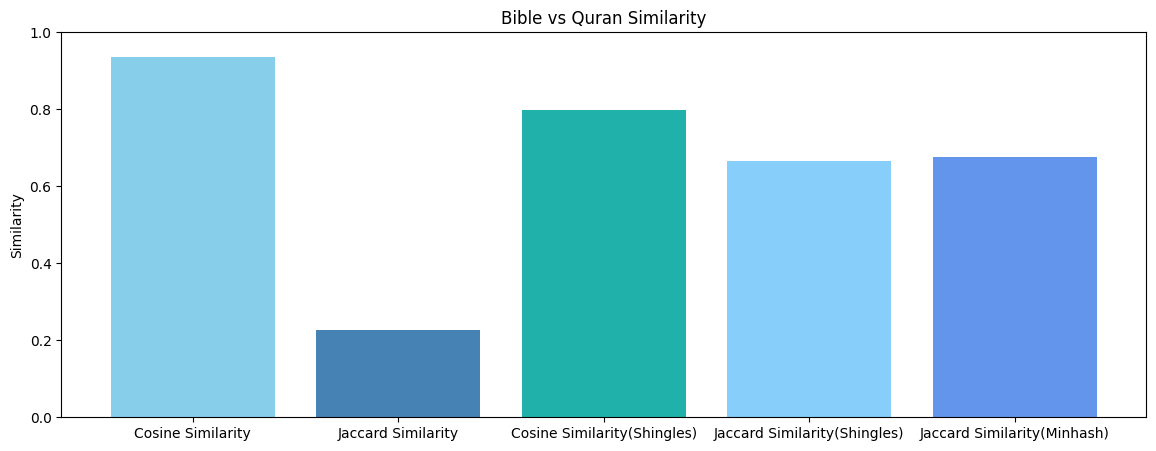

--Similarity--
Cosine: 0.9345640855552494
Jaccard: 0.2258355546442485
Cosine(Shingles): 0.7992195544402725
Jaccard(Shingles): 0.6655001458151064
Jaccard(Minhash): 0.675
-------------------------------------------
Similarity (Percentage)
Cosine:93.45640855552494%
Jaccard:22.58355546442485%
Cosine(Shingles): 79.92195544402725%
Jaccard(Shingles): 66.55001458151064%
Jaccard(Minhash): 67.5%


In [ ]:
labels = ['Cosine Similarity', 'Jaccard Similarity', 'Cosine Similarity(Shingles)', 'Jaccard Similarity(Shingles)','Jaccard Similarity(Minhash)']
similarities = [cosine_sim, jaccard_sim, cosine_sim_shingles, jaccard_sim_shingles, minhash_similarity]

plt.figure(figsize=(14, 5))
plt.bar(labels, similarities, color=['skyblue', 'steelblue', 'lightseagreen', 'lightskyblue', 'cornflowerblue'])
plt.ylim(0, 1)
plt.ylabel('Similarity')
plt.title("Bible vs Quran Similarity")
plt.show()

print("--Similarity--")
print(f"Cosine: {cosine_sim}")
print(f"Jaccard: {jaccard_sim}")
print(f"Cosine(Shingles): {cosine_sim_shingles}")
print(f"Jaccard(Shingles): {jaccard_sim_shingles}")
print(f"Jaccard(Minhash): {minhash_similarity}")
print("-------------------------------------------")
print("Similarity (Percentage)")
print(f"Cosine:{cosine_sim*100}%")
print(f"Jaccard:{jaccard_sim*100}%")
print(f"Cosine(Shingles): {cosine_sim_shingles*100}%")
print(f"Jaccard(Shingles): {jaccard_sim_shingles*100}%")
print(f"Jaccard(Minhash): {minhash_similarity*100}%")

### LSH

#### LSH 알고리즘 구현 및 유사한 문장 쌍을 찾는 함수 정의

In [ ]:
def lsh(minhash_vectors, num_bands, rows_per_band):
    assert len(minhash_vectors[0]) == num_bands * rows_per_band, "MinHash 벡터의 길이가 밴드와 행 개수에 맞아야 합니다."

    lsh_buckets = defaultdict(list)
    for doc_id, minhash_vector in enumerate(minhash_vectors):
        for band in range(num_bands):
            start = band * rows_per_band
            end = start + rows_per_band
            band_hash = hash(tuple(minhash_vector[start:end]))
            lsh_buckets[(band, band_hash)].append(doc_id)

    return lsh_buckets

def find_similar_pairs(lsh_buckets, minhash_vectors, threshold=0.6):
    candidate_pairs = set()
    for bucket in lsh_buckets.values():
        if len(bucket) > 1:
            for i in range(len(bucket)):
                for j in range(i + 1, len(bucket)):
                    candidate_pairs.add((bucket[i], bucket[j]))

    similar_pairs = []
    for doc1, doc2 in candidate_pairs:
        jaccard_sim = jaccard_similarity_minhash(minhash_vectors[doc1], minhash_vectors[doc2])
        if jaccard_sim >= threshold:
            similar_pairs.append((doc1, doc2, jaccard_sim))

    return similar_pairs

#### 유사한 문장 쌍 찾기

In [ ]:
def read_documents_from_dir(directory):
    documents = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".txt"):
            with open(os.path.join(directory, file_name), "r", encoding="utf-8") as file:
                documents.append(file.read())
    return documents

bible_documents = read_documents_from_dir(bible_dir)
quran_documents = read_documents_from_dir(quran_dir)

num_bands = 200
rows_per_band = len(bible_minhash) // num_bands

minhash_vectors = [bible_minhash, quran_minhash]
lsh_buckets = lsh(minhash_vectors, num_bands, rows_per_band)

threshold = 0.6
similar_pairs = find_similar_pairs(lsh_buckets, minhash_vectors, threshold)

if similar_pairs:
    print("유사한 문장 쌍:")
    for doc1, doc2, sim in similar_pairs:
        source1 = "Bible" if doc1 == 0 else "Quran"
        source2 = "Bible" if doc2 == 0 else "Quran"
        print(f"{source1}:\n{bible_documents[doc1] if doc1 == 0 else quran_documents[doc1]}")
        print("\n")
        print(f"{source2}:\n{bible_documents[doc2] if doc2 == 0 else quran_documents[doc2]}")
        print(f"유사도: {sim}\n")
else:
    print("유사한 문장이 발견되지 않았습니다.")

유사한 문장 쌍:
Bible:
Chapter: 29
the word of the lord that came to joel the son of pethuel.
hear this ye old men and give ear all ye inhabitants of the land.
hath this been in your days or even in the days of your fathers.. tell ye your children of it and let your children tell their children and their children another generation.
that which the palmerworm hath left hath the locust eaten and that which the locust hath left hath the cankerworm eaten and that which the cankerworm hath left hath the caterpiller eaten.
awake ye drunkards and weep and howl all ye drinkers of wine because of the new wine for it is cut off from your mouth.
for a nation is come up upon my land strong and without number whose teeth are the teeth of a lion and he hath the cheek teeth of a great lion.
he hath laid my vine waste and barked my fig tree he hath made it clean bare and cast it away the branches thereof are made white.
lament like a virgin girded with sackcloth for the husband of her youth.
the meat offeri